In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
import pandas as pd
from imblearn.combine import SMOTEENN
import time

In [2]:
data_dir = r'D:\Kuliah\Semester 7\PCD\New\dataset\hmnist_28_28_RGB.csv'
data = pd.read_csv(data_dir)
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [3]:
y = data['label']
x = data.drop(columns = ['label'])

In [4]:
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [5]:
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (46935, 28, 28, 3)


In [6]:
unique_classes, class_counts = np.unique(y, return_counts=True)
for cls, count in zip(unique_classes, class_counts):
    print(f"Kelas {cls}: {count} sampel")

Kelas 0: 6705 sampel
Kelas 1: 6705 sampel
Kelas 2: 6705 sampel
Kelas 3: 6705 sampel
Kelas 4: 6705 sampel
Kelas 5: 6705 sampel
Kelas 6: 6705 sampel


In [7]:
tabular_data = pd.read_csv(r'D:\Kuliah\Semester 7\PCD\New\dataset\HAM10000_metadata.csv')
tabular_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [8]:
classes = {4: ('nv', ' melanocytic nevi'), 
           6: ('mel', 'melanoma'), 
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'), 
           5: ('vasc', ' pyogenic granulomas and hemorrhage'), 
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  
           3: ('df', 'dermatofibroma')}

In [9]:
t = np.zeros([46935, 32, 32, 3],dtype=np.float32)
print(t.shape)

(46935, 32, 32, 3)


In [10]:
import scipy.ndimage

In [11]:
for i in range(46935):
    t[i] = scipy.ndimage.zoom(x[i],32/28)

In [12]:
x = np.array(t).reshape(-1,32,32,3)
print('Shape of X :',x.shape)

Shape of X : (46935, 32, 32, 3)


In [13]:
"""Standardization and Splitting Data"""

x = (x-np.mean(x))/np.std(x)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

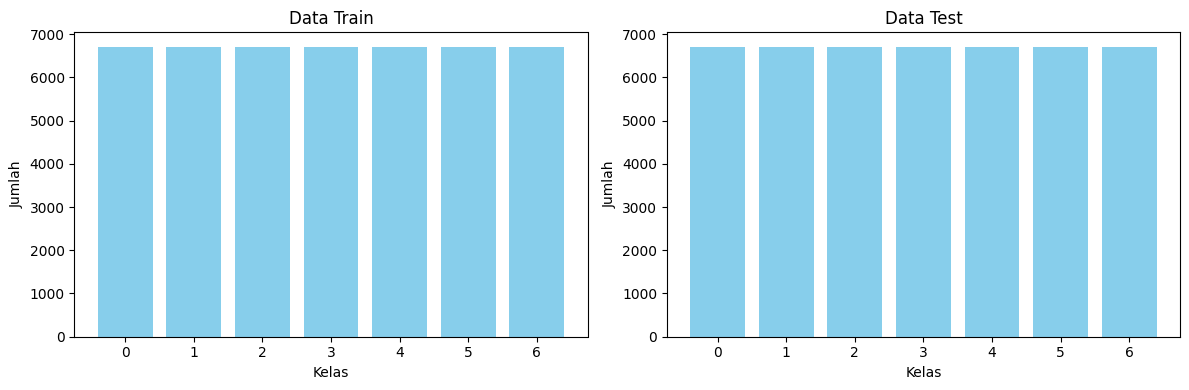

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

class_counts = y.value_counts().sort_index()
ax1.bar(class_counts.index, class_counts.values, color='skyblue')
ax1.set_xlabel('Kelas')
ax1.set_ylabel('Jumlah')
ax1.set_title('Data Train')

class_counts_oversample = y.value_counts().sort_index()
ax2.bar(class_counts_oversample.index, class_counts_oversample.values, color='skyblue')
ax2.set_xlabel('Kelas')
ax2.set_ylabel('Jumlah')
ax2.set_title('Data Test')

plt.tight_layout()
plt.show()

In [15]:
from keras.applications.densenet import DenseNet201
base_model = DenseNet201(input_shape=(32,32,3),weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    Flatten(),
    Dense(64, activation='relu'),
    Dense(7, activation='softmax')
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1, 1, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 64)                122944    
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                                 
Total params: 18445383 (70.36 MB)
Trainable params: 123399 (482.03 KB)
Non-trainable params: 18321984 (69.89 MB)
_________________________________________________________________
None


In [17]:
# Callback untuk menghentikan pelatihan jika validasi loss tidak berubah dalam beberapa epoch
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validasi loss
    patience=5,  # Jumlah epoch tanpa perubahan sebelum menghentikan pelatihan
    verbose=1,  # Menampilkan pesan ketika menghentikan pelatihan
    restore_best_weights=True  # Mengembalikan bobot terbaik saat menghentikan pelatihan
)

callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model_densenet.h5',
                                              monitor='val_loss',
                                              save_best_only=True,
                                              save_weights_only=False,
                                              mode='max',
                                              verbose=1)

In [18]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 70,
                    callbacks=([callback], [early_stopping_callback]))

Epoch 1/70
235/235 [==============================] - ETA: 0s - loss: 1.0197 - accuracy: 0.6187
Epoch 1: val_loss improved from -inf to 0.78529, saving model to best_model_densenet.h5


C:\Users\Fenny Puspitasari\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


235/235 [==============================] - 114s 450ms/step - loss: 1.0197 - accuracy: 0.6187 - val_loss: 0.7853 - val_accuracy: 0.7108
Epoch 2/70
235/235 [==============================] - ETA: 0s - loss: 0.6394 - accuracy: 0.7777
Epoch 2: val_loss did not improve from 0.78529
235/235 [==============================] - 92s 391ms/step - loss: 0.6394 - accuracy: 0.7777 - val_loss: 0.5844 - val_accuracy: 0.7956
Epoch 3/70
235/235 [==============================] - ETA: 0s - loss: 0.4906 - accuracy: 0.8333
Epoch 3: val_loss did not improve from 0.78529
235/235 [==============================] - 94s 399ms/step - loss: 0.4906 - accuracy: 0.8333 - val_loss: 0.4965 - val_accuracy: 0.8292
Epoch 4/70
235/235 [==============================] - ETA: 0s - loss: 0.3920 - accuracy: 0.8700
Epoch 4: val_loss did not improve from 0.78529
235/235 [==============================] - 97s 414ms/step - loss: 0.3920 - accuracy: 0.8700 - val_loss: 0.4091 - val_accuracy: 0.8607
Epoch 5/70
235/235 [==============

In [19]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (16, 4))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, label= 'Training loss')
    plt.plot(Epochs, val_loss, label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc,  label= 'Training Accuracy')
    plt.plot(Epochs, val_acc,  label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()
    

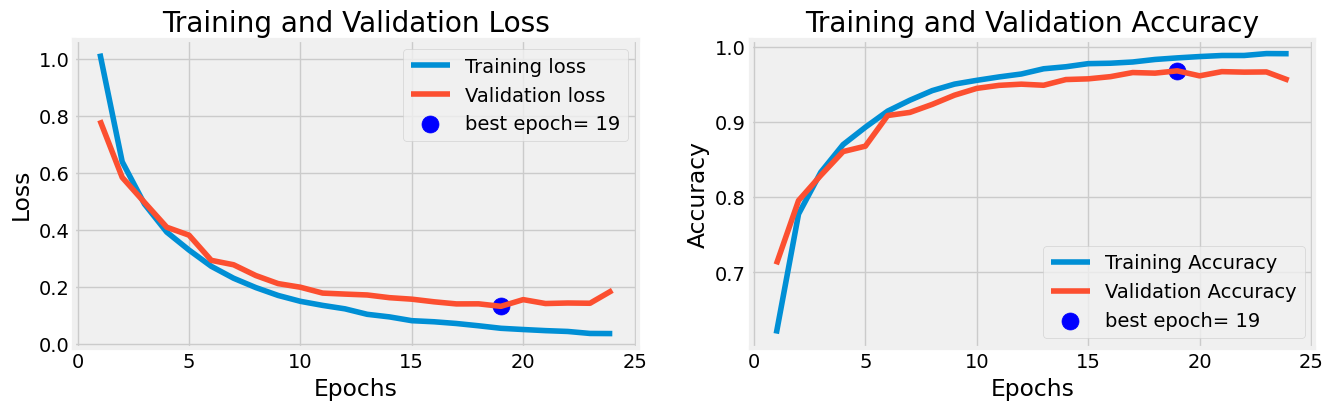

In [20]:
plot_training(history)

In [21]:
train_score = model.evaluate(X_train, Y_train, verbose= 1)
test_score = model.evaluate(X_test, Y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

294/294 [==============================] - 26s 89ms/step - loss: 0.1341 - accuracy: 0.9653
Train Loss:  0.06243211776018143
Train Accuracy:  0.9861244559288025
--------------------
Test Loss:  0.1341058313846588
Test Accuracy:  0.9652711153030396


In [22]:
y_pred = model.predict(X_test)

294/294 [==============================] - 29s 90ms/step


In [23]:
y_pred = np.argmax(y_pred, axis=1)

In [24]:
y_true = Y_test.to_numpy()

In [25]:
from sklearn.metrics import accuracy_score, classification_report

# Assuming y_true is a NumPy array or a list and y_pred is a NumPy array
accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred)

In [26]:
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9652711196335357
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1359
           1       0.99      1.00      1.00      1318
           2       0.93      0.98      0.95      1262
           3       0.99      1.00      0.99      1351
           4       0.94      0.84      0.88      1374
           5       1.00      1.00      1.00      1358
           6       0.92      0.95      0.93      1365

    accuracy                           0.97      9387
   macro avg       0.97      0.97      0.96      9387
weighted avg       0.97      0.97      0.96      9387



In [27]:
classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

In [28]:
from sklearn.metrics import confusion_matrix
import itertools

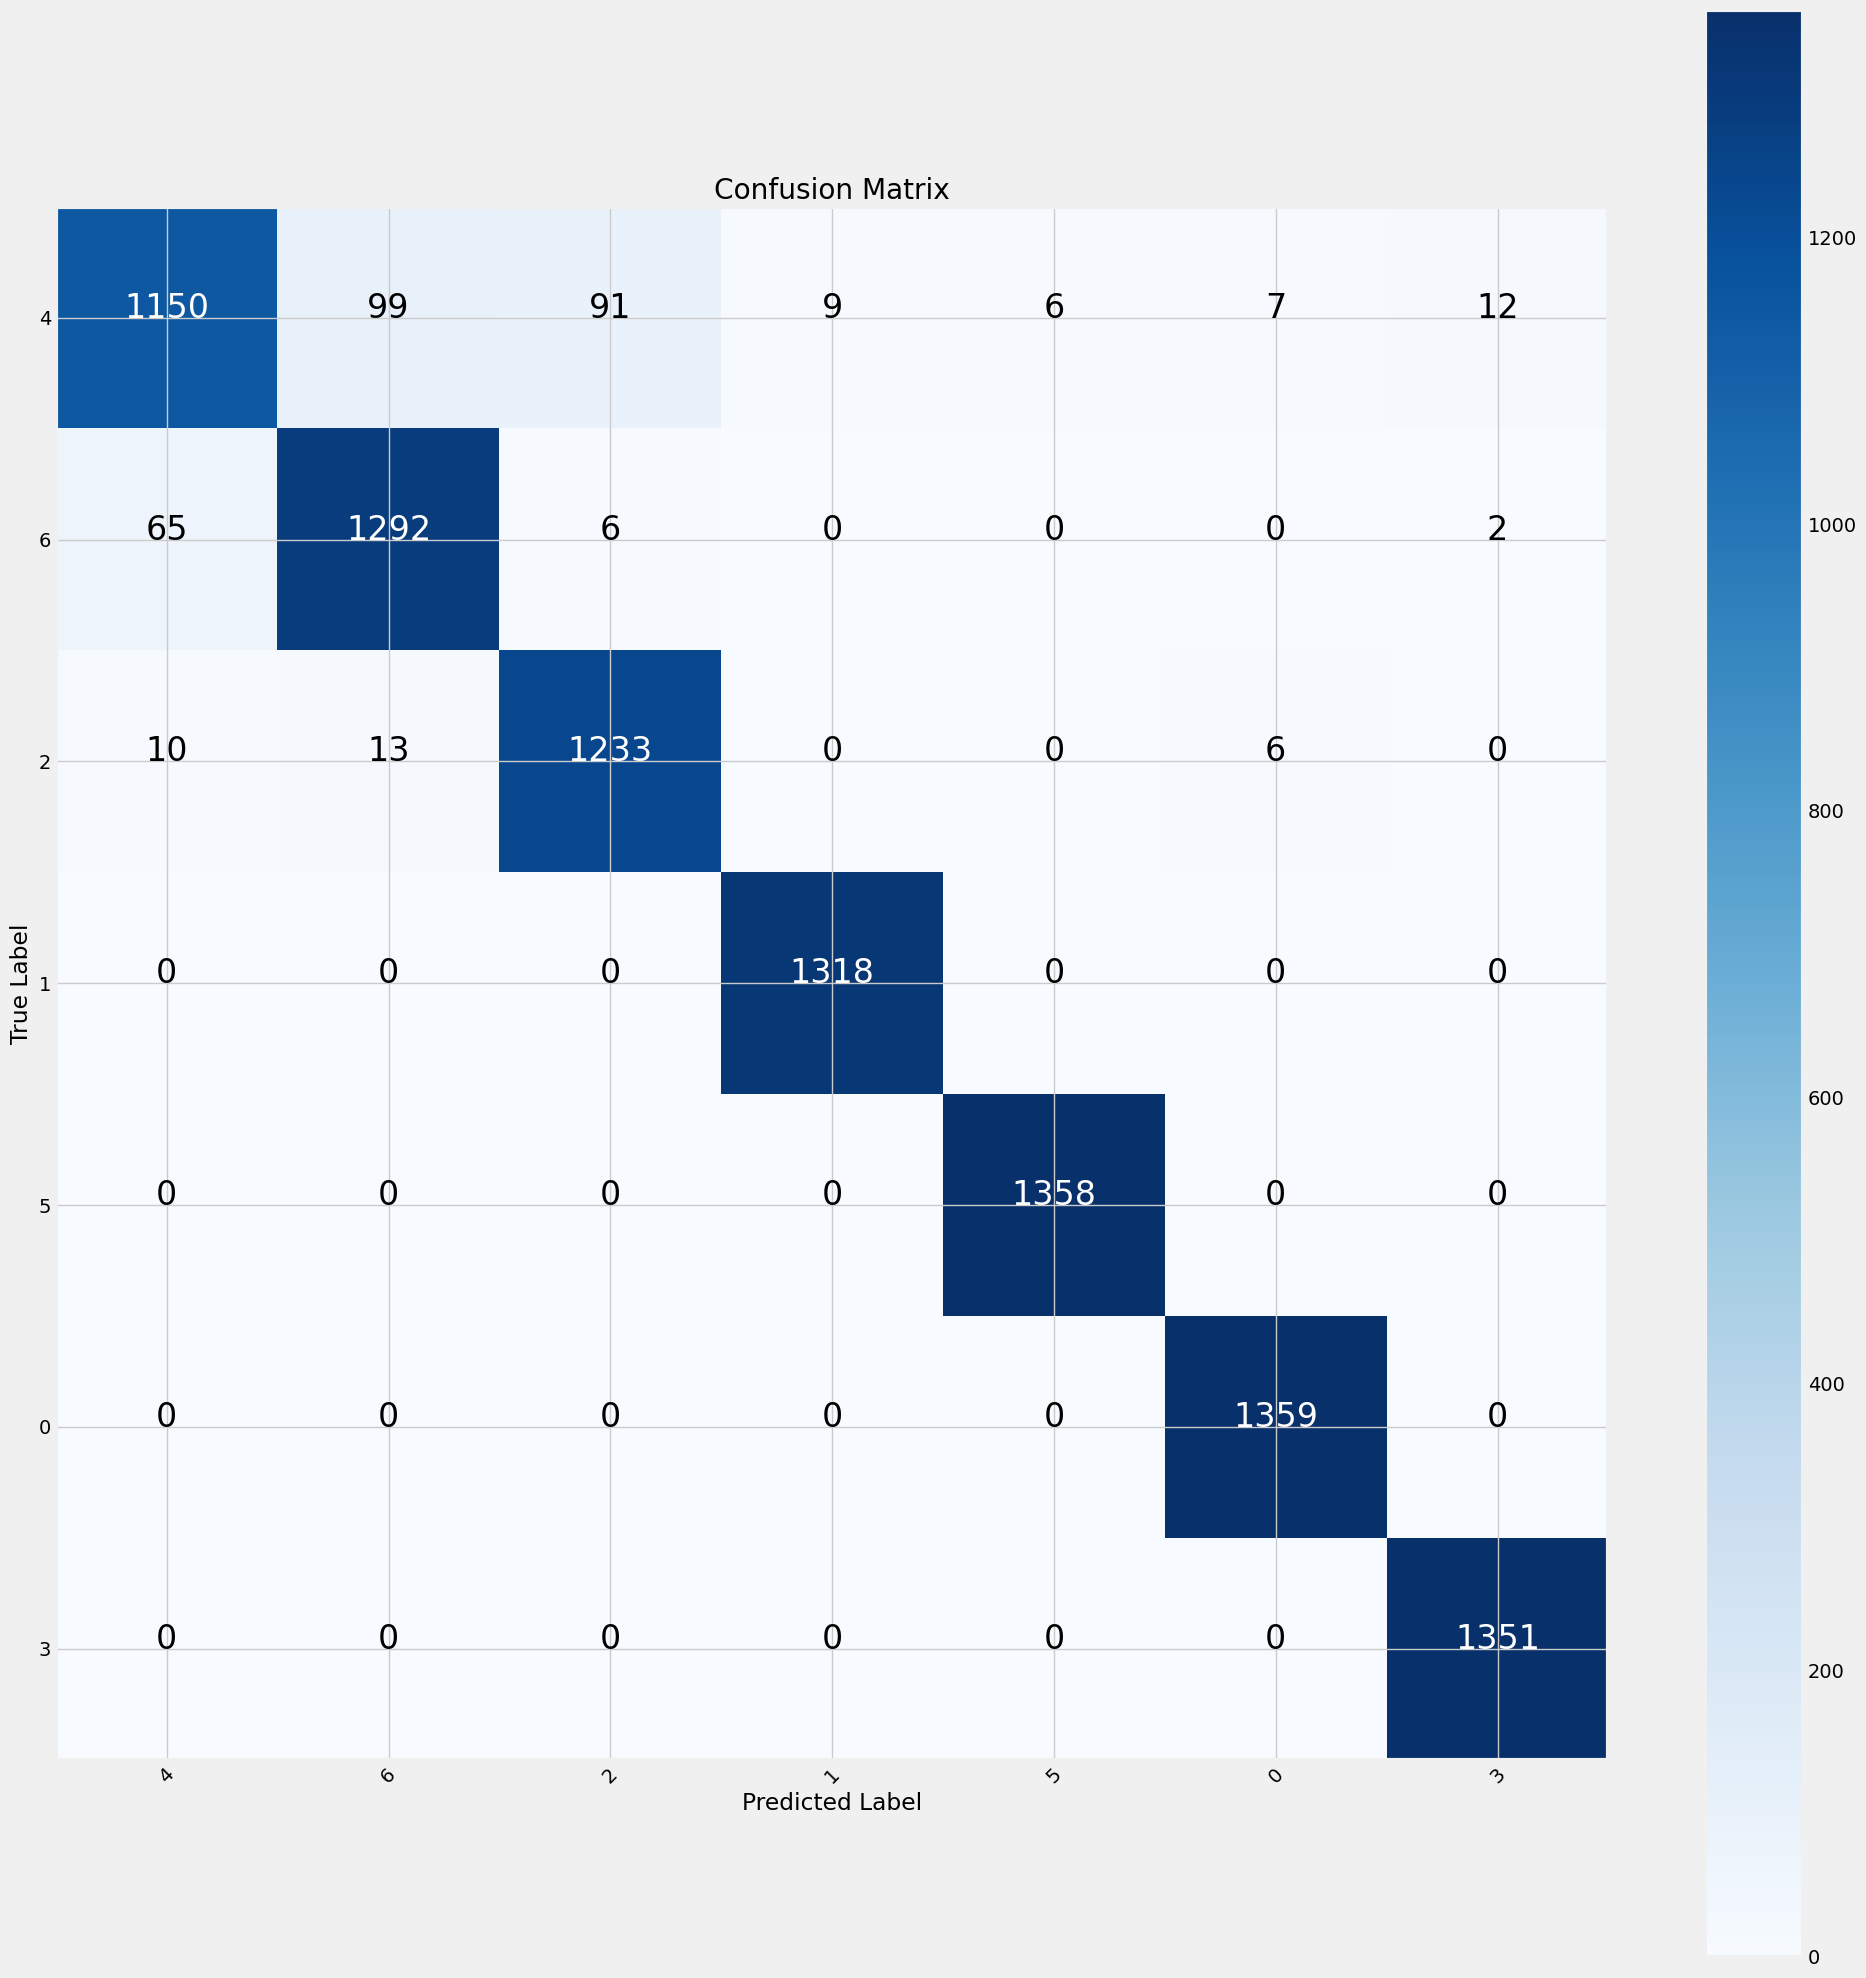

In [29]:
# Confusion matrix
cm = cm = confusion_matrix(y_true, y_pred, labels=classes_labels)

plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black', fontsize=24)

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()